### Validating Logistic Regression model: Decile Analysis
The main focus of this exercise is to use **decile analysis** to evalute the performance of a **logistic regression** model.
This will include **decile chart** and **lift chart** and their visualizations.
Binary classifications also use the **Area Under Curve (AUC)** and the **Kolmogorov–Smirnov (KS) distance** to evaluate the model. We shall also calculate and interpret these statistics. 

### Load required packages

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, linear_model, preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import cross_validate
%matplotlib inline

sns.set(color_codes = True) 
import warnings
warnings.filterwarnings('ignore')

### Simple Regression models
Let's kick-off with a simple **linear regression** problem so we would be able to see why **logistic regression** is different.

It is obvious that eating more would increase a person's weight while workout exercise would lead to a decrease in weight (all things being equal). We will use a simple dataset to develop a model that can be use to predict a person's **weight** given the amount of food intake (**foodintake**) and the number of hours spent in the gym (**workoutime**).

#### Load dataset

In [2]:
path = '../data/body_weight.csv'
raw_data = pd.read_csv(path, na_values = 'NA')
raw_data.head(3)

,Person_ID,Workouttime,Foodintake,Weight
0,1,30,0.6,73
1,2,0,1.2,92
2,3,10,0.8,80


**I like variable names to in lower case for convinience...**

In [3]:
df = raw_data.rename(columns = {'Person_ID': 'Person_ID'.lower(), 'Workouttime': 'Workouttime'.lower()})
df = df.rename(columns = {'Foodintake': 'Foodintake'.lower(), 'Weight': 'Weight'.lower()})
print(df.shape)
df.head(3)

(31, 4)


,person_id,workouttime,foodintake,weight
0,1,30,0.6,73
1,2,0,1.2,92
2,3,10,0.8,80


**Generate training data (X_train) and target (y_train)**

In [4]:
X_train = df.drop(['weight', 'person_id'], axis = 1)    # X_train = df['workouttime', 'foodintake']
y_train = df.weight

#### Check the distribution of the target variable
One of the most important **assumptions of linear regression** is that the **target variable should be normally distributed**. This is because only the **target** variable is considered to be **random**. The independent variable or inputs must not be normally distributed.

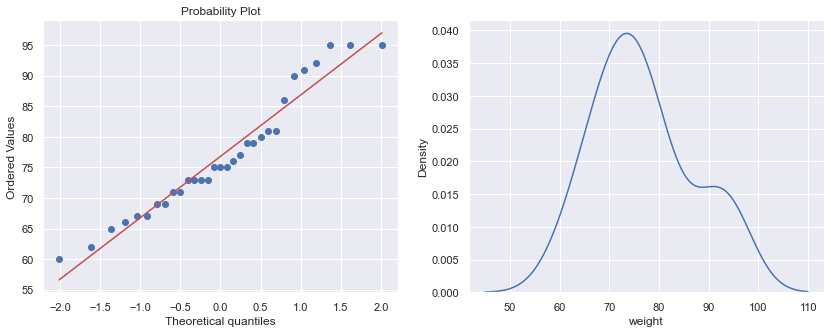

In [5]:
#sns.displot(y_train)      # `distplot` is a deprecated
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
stats.probplot(y_train, dist = 'norm', plot = ax[0])                # qq-plot
sns.kdeplot(y_train, ax = ax[1])
plt.show()

From the **qq-plot** and the **kdeplot** we can see that the independent variable or **target** is *somehow* **normally** distributed. The target **Weight** is crowded around the **ideal normally distributed red line**. This means we can safely apply **linear regression** method. 

### The model

In [6]:
lin_reg = linear_model.LinearRegression()          
lin_reg.fit(X_train, y_train)                      
print(f'Intercept = {lin_reg.intercept_}\nCoefficients = {lin_reg.coef_}')   

Intercept = 63.4308764464608
Coefficients = [-0.17471439 24.46980569]


* The first coefficient is **negative (-0.17471439)**. This corresponds to **workouttime**. Increase in this input variable would lead to a reduction in the target **weight**. 

* The second coefficient is **positive (24.46980569)**. This corresponds to **foodintake**. Increase in this input variable would lead to an increase in the target **weight**.

* The model can be written as $weight = 24.46980569 x foodintake - 0.17471439 x workouttime + 63.4308764464608$

### The prediction function

In [7]:
def predict_weight(foodintake, workouttime):
    return 24.46980569 * foodintake - 0.17471439 * workouttime + 63.4308764464608

In [8]:
foodintake, workouttime = 0.6, 30                         # predict the first observation
print(f'weight = {round(predict_weight(foodintake, workouttime), 1)}')

weight = 72.9


In [9]:
foodintake, workouttime = 0.8, 10                         # predict the 3rd observation
print(f'weight = {round(predict_weight(foodintake, workouttime), 1)}')

weight = 81.3


#### Get the R-square score
**R-square** measures the **predictive power** of the model. It can be calculated using the **`score`** method of the regression object. **R-square** can be calculated manually as follows: 

$R^2 = \frac{\sum{(y_{pred} - \bar{y}_{pred})^2}}{\sum{(y - \bar{y})^2}}$

In [10]:
print(f'R^2 = {lin_reg.score(X_train, y_train)}')

R^2 = 0.8685312512454116


#### Prediction using our model

In [11]:
y_pred = lin_reg.predict(X_train)     # predict the target from the training data
print(y_pred)

[72.87132807 92.79464327 81.25957706 70.07687685 84.40639427 75.66577929
 70.59808283 71.82402078 92.79464327 68.67720357 81.9594137  73.57116471
 66.93201777 86.85337484 83.006721   70.59808283 60.28895457 92.79464327
 63.25909925 81.08584174 73.57116471 75.66577929 75.84147275 71.82402078
 92.79464327 68.67720357 79.51145407 70.59808283 69.72646899 91.9210713
 69.55077553]


### Calculating some statstics
* Mean Square Error (MSE)
* Mean Square Regression (MSR)
* F statistics = MSR/MSE
* p value = Prob(f>F)

In [12]:
n = y_train.size                         # total sample size of target variable: len(y_train)
m = 2                                    # number of independent variables (Workouttime, Foodintake)
dfn = m                                  # degree of freedom for Mean Square Regression (MSR) 
dfd = n - m - 1                          # degree of freedom for Mean Square Error (MSE)
y_avg = np.mean(y_train)                 # mean value of target variable

sst = np.sum((y_train - y_avg) ** 2)     # total variance of the target variable
sse = np.sum((y_train - y_pred) ** 2)    # total model prediction error
ssr = sst - sse                          #

mse_model = sse / dfd                    # MSE  (mean value)
msr_model = ssr / dfn                    # MSR
F = msr_model / mse_model                # if large enough then one of the independent variables can be used in the model

p_value = 1.0 - stats.f.cdf(F, dfn, dfd)       # get the p value
r_sq = ssr / sst

print(f'F-statistics: {round(F, 3)}\npvalue: {round(p_value, 3)}\nR-square = {np.round(r_sq, 3)}\n')

alpha = 0.05
if p_value <= alpha:
    print('At least one of the input variables is correlated with the target and can be used as a predictor for the target')

F-statistics: 92.489
pvalue: 0.0
R-square = 0.869

At least one of the input variables is correlated with the target and can be used as a predictor for the target


The **p-value: 0.0** is extremely small suggesting that at least one of the independednt variables **(workouttime, foodintake)** can be used in the model to predict the target **weight**.

**R-square = 0.869** is high enough to suggest that the model is good.

### Confirming the model and key statistics using `ols`
**Ordinary Least Square (OLS)** is also a **linear regression** fitting method which can be used to obtain the same model as **scikit learn's** linear regression. However, it gives us **additional statistics** out of the box as we'll see shortly.

In [13]:
model = ols('weight ~ workouttime + foodintake', data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     92.49
Date:                Fri, 13 May 2022   Prob (F-statistic):           4.61e-13
Time:                        23:13:12   Log-Likelihood:                -83.133
No. Observations:                  31   AIC:                             172.3
Df Residuals:                      28   BIC:                             176.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      63.4309      2.530     25.068      

In [14]:
r_square = model.rsquared
print(f'R^2 = {r_square}')

intercept = model.params['Intercept']
coef_workouttime = model.params['workouttime']
coef_foodintake = model.params['foodintake']
print(f'Intercept = {intercept}\nCoef(workouttime) = {coef_workouttime}\nCoef(foodintake) = {coef_foodintake}\n')

pvalue_workouttime = model.pvalues['workouttime']
pvalue_foodintake = model.pvalues['foodintake']
pvalue_model = model.f_pvalue
print(f'pvalue(model) = {round(pvalue_model, 3)}')
print(f'pvalue(workouttime) = {round(pvalue_workouttime, 3)}\npvalue(foodintake) = {round(pvalue_foodintake, 3)}\n')

alpha = 0.05
if pvalue_workouttime <= alpha:
    print('Input variable workouttime is correlated with the target weight and can be used as a predictor for weight')
else:
    print('Input variable workouttime is not correlated with the target weight and cannot be used as a predictor for weight')
print() 

if pvalue_foodintake <= alpha:
    print('Input variable foodintake is correlated with the target weight and can be used as a predictor for weight')
else:
    print('Input variable foodintake is not correlated with the target weight and cannot be used as a predictor for weight')
print()

if pvalue_model <= alpha:
    print('Good model')
else:
    print('Bad model')

R^2 = 0.8685312512454118
Intercept = 63.43087644646078
Coef(workouttime) = -0.17471439302124606
Coef(foodintake) = 24.469805685788685

pvalue(model) = 0.0
pvalue(workouttime) = 0.0
pvalue(foodintake) = 0.0

Input variable workouttime is correlated with the target weight and can be used as a predictor for weight

Input variable foodintake is correlated with the target weight and can be used as a predictor for weight

Good model


We can see that the coefficients and statistics obtained using OLS are same as those obtained using scikit learn.

**OLS** also outputs a **pvalue** for the model. Here the model pvalue indicates that the model is good.

### Visualizations
#### Plot of Prediction vs Prediction Error
For a good model this plot is expected to be **noisy**, without showing any meaningful relationship.

In [15]:
df['pred'] = y_pred
df['error'] = df.weight - df.pred
residual = y_pred - y_train                # prediction error (noise)

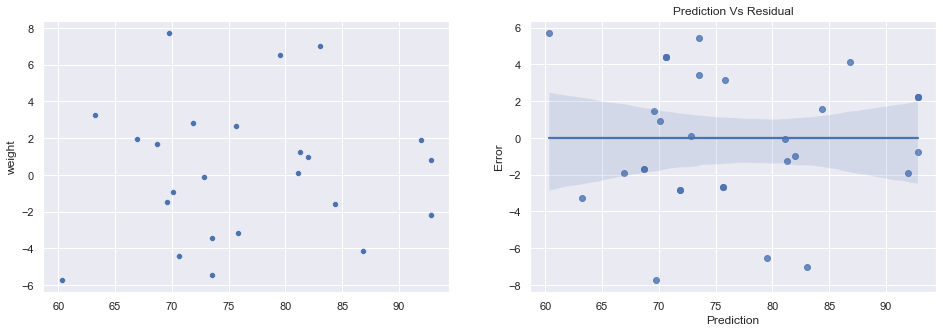

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (16, 5), sharex = True)
sns.scatterplot(x = y_pred, y = residual, ax = axes[0]) 
sns.regplot(x = 'pred', y = 'error', data = df, fit_reg = True, ax = axes[1])
plt.title('Prediction Vs Residual')
plt.xlabel('Prediction')
plt.ylabel('Error')
plt.show()

### Plot of Predictions vs Target 
This is expected be a **linear relationship** for a good model.

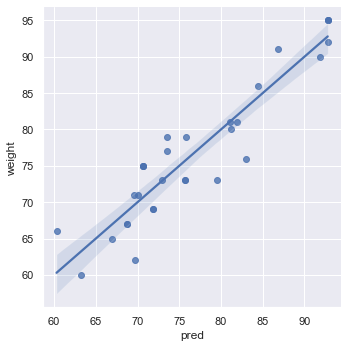

In [17]:
sns.lmplot(x = 'pred', y = 'weight', data = df, fit_reg = True)    # a linear relationship is expected
plt.show()

## Logistic Regression
**Logistic Regression** got its name from *logic*, that is (**1 or 0**), since the algorithm is used to predict the target that is a **binary** variable unlike **Linear Regression** which is used when the target is a **continuous** variable. The general form of logistic regression is given by the equation

$log(\frac{p}{1 - p}) = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_mx_m$

where $p(x)$ is the probability of the target variable **Y** equaling a **success case** and $1 - p(x)$ is probability of the target variable **Y** equaling a **failure case**. 

In our case $p(x)$ is the probability of **owner (1)** while $1 - p(x)$ is probability of **not owner (0)**.

The dataset for this exercise is very simple, with two independent variables **age** and **income** which determine whether a person owns a house (**owner = 1**) or not (**owner = 0**).

In [18]:
path = '../data/owners.csv'
owner_df = pd.read_csv(path, na_values = 'NA')
print(owner_df.shape)
owner_df.head(3)

(28, 4)


,id,age,income,owner
0,1,23,23113,1
1,2,24,20000,0
2,3,45,72000,1


In [19]:
X_train = owner_df.drop(['id', 'owner'], axis = 1)    # axis = 1 means columns
y_train = owner_df.owner

#### Train the model

In [20]:
log_reg = linear_model.LogisticRegression(C = 1e5, penalty = 'l2')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_train)        # predict probabilities
y_pred[:10]              

array([[4.86094998e-01, 5.13905002e-01],
       [5.85262213e-01, 4.14737787e-01],
       [1.51557196e-02, 9.84844280e-01],
       [9.27294948e-01, 7.27050520e-02],
       [3.76794588e-01, 6.23205412e-01],
       [2.67682994e-01, 7.32317006e-01],
       [7.99214343e-04, 9.99200786e-01],
       [9.72851961e-01, 2.71480392e-02],
       [3.19363956e-03, 9.96806360e-01],
       [7.90760028e-01, 2.09239972e-01]])

### Validating the model using deciles analysis
The output of **`predict_proba`** is a 2D Numpy array where the **second column** is the probability of **owner (1)**,
$p(x)$ and the **first column** is probability of **not owner (0)**, $1 - p(x)$. 

Let's extract $p(x)$ and put in a dataframe along side the target to fascilitate the **decile analysis**.

In [21]:
y_pred_1 = y_pred[:, 1]          
dec = pd.DataFrame({'prob': y_pred_1, 'target': y_train})
dec.head()

,prob,target
0,0.513905,1
1,0.414738,0
2,0.984844,1
3,0.072705,0
4,0.623205,1


### Generate the Deciles chart
**Decile Analysis** is used to categorize a dataset from **highest to lowest** values or **vice versa** (based on **predicted probabilities**). As evident from the name, the analysis involves **dividing the dataset into ten equal groups**.  A **decile** is any of the **nine** values that divide the sorted data into **ten equal parts**, so that each part represents **1/10** of the sample or population. A **decile** is one possible form of a **quantile** like the **quartile** and **percentile**.

**However, because our dataset is very small we will devide it into 4 equal groups**. This is not affect the analysis.

#### Helper function to generate ranking groups using `pd.qcut()`
We will use **`pd.qcut`** to generate **ranking buckets**.

In [22]:
def grouping(df, grp_num):
    grp = pd.qcut(df['prob'], grp_num, labels = False)      # ranking membership for each score  
    df['ranks'] = grp
    return df

In [23]:
dec_copy = dec.copy()
dec_val = grouping(dec_copy, 4)              # we are using 4 groups 0-3 and not the usual 10 groups
dec_val[['target', 'prob', 'ranks']].head(10)

,target,prob,ranks
0,1,0.513905,1
1,0,0.414738,1
2,1,0.984844,3
3,0,0.072705,0
4,1,0.623205,2
5,1,0.732317,2
6,1,0.999201,3
7,0,0.027148,0
8,1,0.996806,3
9,0,0.209240,1


Membership ranks ranges from **0 - 3** with **3** being the **highest or best** ranking and **0** the lowest.
### Generate Group chart
We shall group the deciles by ranks and get the **mean target** and **mean probability**. The **mean target** will tell us whether we have more **owners(1)** or more **non-owners(0)** in a particular decile. The **mean probability** will indicate whether the group was generally predicted correctly or not. We will also get the number of targets (**owners and non-owners**) in a decile group.

In [24]:
val_grp = dec_val.groupby('ranks')
bucket = val_grp[['target', 'prob']].mean()
ct = val_grp[['target']].count()                        # count how many members per group
#ct = dec_val.ranks.value_counts().sort_index()         # alternatively
bucket['count'] = ct

bucket = bucket.sort_values(by = 'prob', ascending = False)
bucket_df =  bucket.reset_index()
bucket_df

,ranks,target,prob,count
0,3,1.000000,0.979485,7
1,2,0.714286,0.685659,7
2,1,0.333333,0.330082,6
3,0,0.000000,0.045438,8


* In the highest ranked group (**3**) there are **7** persons and the **average target = 1** meaning **everybody** is an **owner(1)**. It also has the **highest** mean probability **0.979485**.

* In the second ranked group (**2**) there are **7** persons and the **average target = 0.714286** meaning **71%** of the people are **owner(1)** and **29%** are **non-owner(0)**. That means **29% error**!. This group has the mean probability **0.685659**.

* In the lowest ranked group (**0**) there are **8** persons and the **average target = 0** meaning **everybody** is a **non-owner(0)**. It also has the lowest mean probability **0.045438**.

In conclusion, the model is not bad. The **probability follows the target** in trend - i.e the **probability is decreasing as we move from highest to lowest rank**.

### Visualisation

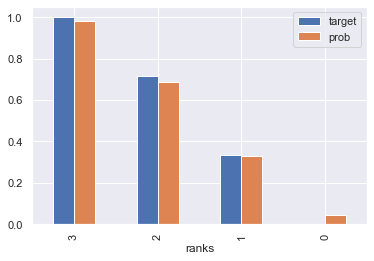

In [25]:
bucket1 = bucket_df.drop(['count'], axis = 1).set_index(['ranks'])
bucket1.plot(kind = 'bar')
plt.show()

The plot above again demonstrates that the model is working. The **average target** and **average probability** are close to each other in each group. This means that the **error is small**.

### Calculate Lift
**Lift** is the **ratio of the number of positive observations up to decile `i` using the model to the expected number of positives up to that decile `i` based on a random guesses**. 

Lift chart is the chart between the **lift on the vertical axis** and the corresponding **decile (rank) on the horizontal axis**. Lift is calculated as follows:

$Lift = \frac{Cummulative number of positive observations upto decile i using ML model}{Cummulative number of positive observations upto decile i using random guesses}$

The **Lift Chart measures the effectiveness of models** by calculating the **ratio between the result obtained with a model and the result obtained without a model**.

In [26]:
dec_val.head()

,prob,target,ranks
0,0.513905,1,1
1,0.414738,0,1
2,0.984844,1,3
3,0.072705,0,0
4,0.623205,1,2


In [27]:
bucket.head()

,target,prob,count
ranks,,,
3,1.000000,0.979485,7
2,0.714286,0.685659,7
1,0.333333,0.330082,6
0,0.000000,0.045438,8


In [28]:
target_rate = dec_val.target.mean()                          # mean of all target
bucket['lift'] = 100 * bucket['target'] / target_rate        # bucket['target'] is avg target per bucket 
bucket.head()

,target,prob,count,lift
ranks,,,,
3,1.000000,0.979485,7,200.000000
2,0.714286,0.685659,7,142.857143
1,0.333333,0.330082,6,66.666667
0,0.000000,0.045438,8,0.000000


In [29]:
bucket2 = bucket.drop(['count', 'target', 'prob'], axis = 1)
bucket2.head()

,lift
ranks,
3,200.000000
2,142.857143
1,66.666667
0,0.000000


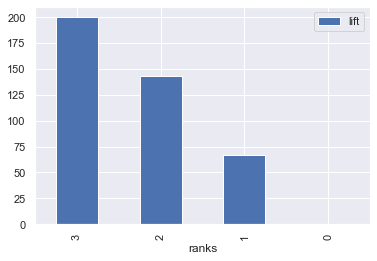

In [30]:
bucket2.plot(kind = 'bar')
plt.show()

The bars show the factor by which **the model outperforms a random assignment of non-owners (0) and owners (1)**. Reading the first bar on the left, we see that taking the **25%** of the records that are ranked by the model as "the most probable **owners (1)**" yields about **200%** as many **owners (1)** as would a random selection of **25%** of the records.

### Receiver Operating Characteristics(ROC) and Area Under Curve(AUC) 
The area under the ROC is widely used to validate classification models. The **closer AUC is to 1 or 100% the better the model**.

In [32]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_1)     # fpr = False Positive Rate, tpr = True Positive Rate
auc = auc(fpr, tpr)                                     # Area Under Curve
print(auc)

0.923469387755102


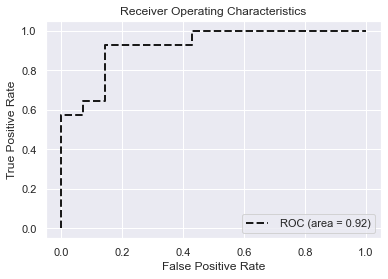

In [33]:
plt.plot(fpr, tpr, 'k--', label = f' ROC (area = {round(auc, 2)})', lw = 2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc = 'lower right')
plt.show()

* The **Area Under Curve (AUC)** should higher than **0.5**, the closer it is to **1** the better.
* An AUC of **0.5** is the same as **random picking**
* A **too high AUC** might be a sign of **overfitting**

#### KS distance 
This is the difference between TPR and FPR. A KS distance of above **40%** is considered good!

In [34]:
kss = np.abs(tpr - fpr)             
ks = kss.max()                      # max distance
print(f'KS of the model is: {ks}')

KS of the model is: 0.7857142857142858
